# Dimensionality Reduction - Data Compression & Decompression Using PCA


In this notebook we explore the following applications of Principle Component Analysis (PCA).

- Data Compression
- Data Decompression


## Dataset: MNIST

We use the MNIST (Modified National Institute of Standards and Technology) dataset, which is a set of 70,000 small images of digits handwritten by high school students and employees of the US Census Bureau. Each image is labeled with the digit it represents.

There are 70,000 images. Each image is **grayscale 28 x 28 pixels**, and each feature simply represents one pixel’s intensity, from 0 (white) to 255 (black).

Thus, each image has **784 features**. 

In [1]:
import warnings
import time
import numpy as np
import pandas as pd
from scipy.io import loadmat
import copy 
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl


from sklearn.datasets import fetch_openml
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA

## Load Data, Create Data Matrix (X) & Target Vector (y)

Load the data from a local folder or load it directly from cloud using Scikit-Learn.


In [2]:
# Load the data from the local folder "data"
mnist = loadmat('/Users/hasan/datasets/MNIST/mnist-original.mat')

# Create the data Matrix X and the target vector y
X = mnist["data"].T.astype('float64')
y = mnist["label"][0].astype('int64')


# Load data using Scikit-Learn
#mnist = fetch_openml('mnist_784', cache=False)


# X = mnist["data"].astype('float64')
# y = mnist["target"].astype('int64')


print("\nNo. of Samples: ", X.shape)
print("No. of Labels: ", y.shape)

print("X Type: ", X.dtype)
print("y Type: ", y.dtype)



No. of Samples:  (70000, 784)
No. of Labels:  (70000,)
X Type:  float64
y Type:  int64


# PCA for Data Compression

We can optimize the running-time of a Machine Learning algorithm by reducing the number of features. Our assumption is that the essence or core content of the data does not span along all dimensions. The technique for reducing the dimension of data is known as dimensionality reduction.

We can use the **PCA** dimensionality reduction technique to project the MNIST dataset (784 features) to a lower dimensional space by retaining maximum variance. 

The goal is to see the improvement in training time due to this dimensionality reduction.

Before we apply the PCA, we need to standardize the data.

Note that in PCA we prefer standardization over Min-Max scaling, since we are interested in the components that maximize the variance. 

## Standardize the Data

PCA is influenced by scale of the data. Thus we need to scale the features of the data before applying PCA. 

For understanding the negative effect of not scaling the data, see the following post:

https://scikit-learn.org/stable/auto_examples/preprocessing/plot_scaling_importance.html#sphx-glr-auto-examples-preprocessing-plot-scaling-importance-py

Note that we fit the scaler on the training set and transform on the training and test set. 

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


scaler = StandardScaler()

# Fit on training set only.
scaler.fit(X_train)

# Apply transform to both the training set and the test set.
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## Apply PCA

While applying PCA we can set the number of principle components by the "n_components" attribute. But more importantly, we can use this attribute to determine the % of variance we want to retain in the extracted features.

For example, if we set it to 0.95, sklearn will choose the **minimum number of principal components** such that 95% of the variance is retained.

In [4]:
%%time
pca = PCA(n_components=0.95)

pca.fit(X_train)

CPU times: user 18.5 s, sys: 1.27 s, total: 19.7 s
Wall time: 6.48 s


PCA(copy=True, iterated_power='auto', n_components=0.95, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

## Number of Principle Components

We can find how many components PCA chose after fitting the model by using the following attribute: n_components_

We will see that 95% of the variance amounts to **315 principal components**.

In [5]:
print("Numberof Principle Components: ", pca.n_components_)  

np.sum(pca.explained_variance_ratio_)

Numberof Principle Components:  330


0.950344532174105

## Apply the Mapping (Transform) to both the Training Set and the Test Set

In [6]:
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

## Classification using Logistic Regression

To examine the effect of PCA on the speed of a classification algorithm, we classify the MNIST dataset using Logistic Regression.

We train two Logistic Regression models by using
- Original 784 features
- Reduced number of features (after applying PCA)

We observe that both the running-time and accuracy improve after compressing the features using PCA.

Thus, PCA can speed up some classification algorithms (but not always, e.g., Random Forest classifier performance degrades after using PCA on the dataset).

In [7]:
t0 = time.time()
softmax_lbfgs = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=100)

softmax_lbfgs.fit(X_train, y_train)
t1 = time.time()

duration_softmax_lbfgs = t1 - t0
print("Running Time (Softmax Regression) {:.1f}s.".format(duration_softmax_lbfgs))


y_test_predicted = softmax_lbfgs.predict(X_test)

accuracy_score_test_softmax_lbfgs = np.mean(y_test_predicted == y_test)
print("Test Accuracy (Softmax): ", accuracy_score_test_softmax_lbfgs)


softmax_pca_lbfgs = LogisticRegression(solver='lbfgs', multi_class='multinomial',max_iter=100)

t0 = time.time()
softmax_pca_lbfgs.fit(X_train_pca, y_train)
t1 = time.time()

duration_softmax_pca_lbfgs = t1 - t0
print("\nRunning Time (PCA+Softmax Regression) {:.1f}s.".format(duration_softmax_pca_lbfgs))

y_test_predicted = softmax_pca_lbfgs.predict(X_test_pca)

accuracy_score_test_softmax_pca_lbfgs = np.mean(y_test_predicted == y_test)
print("Test Accuracy (PCA+Softmax): ", accuracy_score_test_softmax_pca_lbfgs)

/Users/hasan/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Running Time (Softmax Regression) 8.7s.
Test Accuracy (Softmax):  0.914

Running Time (PCA+Softmax Regression) 4.1s.
Test Accuracy (PCA+Softmax):  0.9220714285714285


/Users/hasan/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


## Data Decompression

It is possible to decompress the reduced dataset back to 784 dimensions by applying the inverse transformation of the PCA projection. 

However, this will not give us back the original data, since the projection lost a bit of information (within the 5% variance that was dropped), but it will likely be quite close to the original data. 

The mean squared distance between the original data and the reconstructed data (compressed and then decompressed) is called the **reconstruction error**. 

To illustrate the data decompression using PCA, we compress the MNIST dataset down to 154 dimensions, then use the inverse_transform() method to decompress it back to 784 dimensions. 

In [8]:
pca = PCA(n_components = 154)
X_reduced = pca.fit_transform(X_train)
X_recovered = pca.inverse_transform(X_reduced)

print("X_recovered: ", X_recovered.shape)

reconstruction_error = mean_squared_error(X_train, X_recovered)

print("Reconstruction Error: ", reconstruction_error)

X_recovered:  (56000, 784)
Reconstruction Error:  0.17449765473181947


## Visualize a Recovered Digit

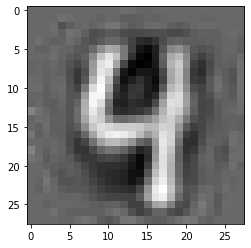

In [9]:
random_digit = X_recovered[2]

random_digit_image = random_digit.reshape(28, 28)

plt.imshow(random_digit_image, cmap = 'gray', interpolation="nearest")
#plt.axis("off")
plt.show()

## Comparison: Original vs. Reconstructed Images

We compare a subset of digits after compression and decompression. 

We see that there is a slight image quality loss, but the digits are still mostly intact.

In [10]:
def plot_digits(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

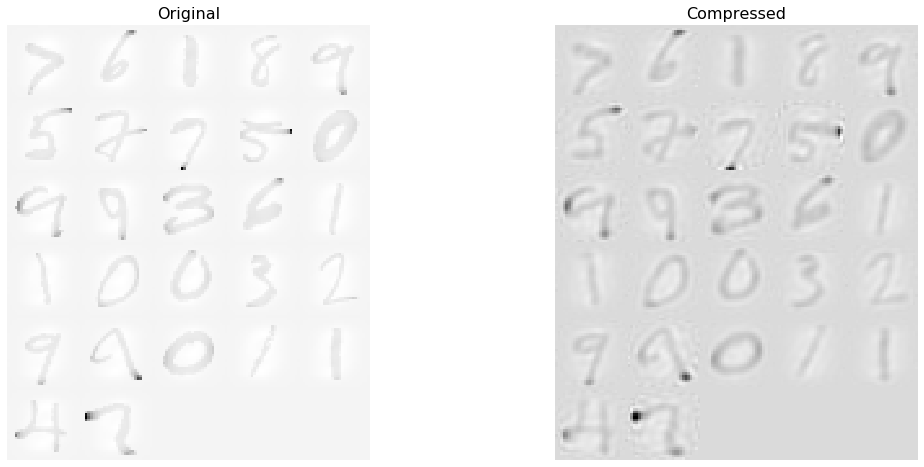

In [11]:
plt.figure(figsize=(18, 8))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.title("Original", fontsize=16)
plt.subplot(122)
plot_digits(X_recovered[::2100])
plt.title("Compressed", fontsize=16)
plt.show()